In this notebook we give a proof of concept of unitary compiling using TFQ. 

In [19]:
%load_ext autoreload
%autoreload 2

import sympy 
import numpy as np 
import pandas as pd 
import tensorflow as tf
from utilities.circuit_database import CirqTranslater
from utilities.templates import *
from utilities.variational import Minimizer
import matplotlib.pyplot as plt 
import tensorflow_quantum as tfq
import cirq
from utilities.compiling import *
from utilities.misc import *
from utilities.simplifier import Simplifier
from utilities.discrimination import *
from utilities.idinserter import IdInserter
from utilities.evaluator import Evaluator
from utilities.gate_killer import GateKiller
from ast import literal_eval
import tensorflow_quantum as tfq
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
etas = np.loadtxt("inputs/inputs.csv")

In [36]:
circuits = {}
costs = {}
optimals = {}
best_found={}
for ets in tqdm(etas):

    translator = CirqTranslater(3, untouchable_blocks = [1], discard_qubits=[2])
    simplifier = Simplifier(translator)
    inserter = IdInserter(translator.n_qubits, untouchable_blocks=translator.untouchable_blocks, untouchable_qubits = [2])
    killer = GateKiller(translator, mode="discrimination", params=ets)
    minimizer = Minimizer(translator, mode="discrimination", params=ets)

    args_evaluator = {"n_qubits":translator.n_qubits, "problem":"acd","params":ets}
    evaluator = Evaluator(args=args_evaluator, lower_bound_cost=minimizer.lower_bound_cost, nrun=0, stopping_criteria=1e-3)

    evaluator.load_dicts_and_displaying(evaluator.identifier)
    [circuit_db, cost, lowest_cost, lower_bound, acceptance_percentage, operation, history] = evaluator.evolution[len(evaluator.evolution.keys())-1]
    costs[str(ets)] = cost
    optimals[str(ets)] = lower_bound
    circuits[str(ets)] = circuit_db
    best_found[str(ets)] = lowest_cost

100%|██████████| 210/210 [01:29<00:00,  2.34it/s]


In [40]:
diffs = np.array(list(costs.values())) - np.array(list(optimals.values()))
diffs_best = np.array(list(best_found.values())) - np.array(list(optimals.values()))

In [37]:
np.min(diffs)

-0.06085134705825568

In [38]:
np.max(diffs)

0.08329091451091997

In [41]:
np.max(diffs_best)

8.651475542631459e-07

In [43]:
np.min(diffs_best)

-0.060851406662900454

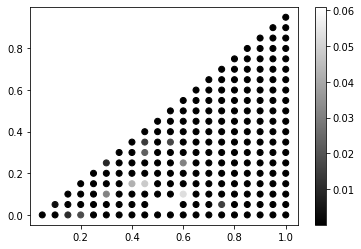

In [46]:
plt.scatter(etas[:,0],etas[:,1], c=np.abs(diffs_best))
plt.gray()
plt.colorbar()

In [48]:
etas[np.argmax(diffs_best)]

array([0.75, 0.7 ])

In [15]:
circuit, circuit_db = translator.give_circuit(circuit_db, unresolved = False)

In [16]:
circuit

(0, 0): ───Rx(π)────────H─────────────X────────────────X───H────────────────X───Rx(-π)───
                                      │                │                    │
(0, 1): ───Rx(0.114π)───Rx(-0.114π)───┼────────────────┼────────────────────┼────────────
                                      │                │                    │
(0, 2): ───H──────────────────────────@───Ry(0.318π)───@───H───Ry(0.318π)───@────────────